In [95]:
import numpy as np
import pandas as pd
import spacy as sp
import string

from statistics import mean
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from numpy import nan

## Plik: Analiza Anotacji
Wczytanie bazy zaanotowanych argumentów dotyczących zdrowia z pliku .csv

In [96]:
argumentacje_z_anotacja_df = pd.read_csv("./dane/Baza argumentacji dotyczącej zdrowia - anotacja.csv", delimiter=",",
                           usecols=["Typ argumentu (szeregowy lub równoległy)", "Konkluzja", "Pos_sentiment_K", "Neg_sentiment_K", "Przesłanka 1", "Pos_sentiment_1",
                                    "Neg_sentiment_1", "Przesłanka 2", "Pos_sentiment_2", "Neg_sentiment_2",
                                    "Przesłanka 3", "Pos_sentiment_3", "Neg_sentiment_3", "Przesłanka 4", "Pos_sentiment_4",
                                    "Neg_sentiment_4", "Przesłanka 5", "Pos_sentiment_5", "Neg_sentiment_5", "Przesłanka 6",
                                    "Pos_sentiment_6", "Neg_sentiment_6", "Przesłanka 7", "Pos_sentiment_7", "Neg_sentiment_7",
                                    "Przesłanka 8", "Pos_sentiment_8", "Neg_sentiment_8"]).fillna(0)  # usunąć fillna aby zobaczyć ilość przesłanek

Sprawdzanie liczby argumentów poszczególnych typów.

In [97]:
argumentacje_z_anotacja_df['Typ argumentu (szeregowy lub równoległy)'].value_counts()

równoległy    146
szeregowy     104
mieszany        1
Name: Typ argumentu (szeregowy lub równoległy), dtype: int64

## Plik: Analiza NAWL
Wczytanie polskiej bazy słów

In [98]:
nlp = sp.load("pl_core_news_lg")

Wczytanie bazy NAWL z pliku .csv i konwersja kolumny z walencjami na liczby

In [99]:
data = pd.read_csv("./dane/nawl_val_aro.csv", delimiter=";", decimal=',')
data['val_M_all'] = data['val_M_all'].astype(float)

Przypisanie słów z bazy NAWL do zmiennej

In [100]:
nawl_words = data.NAWL_word

Wczytanie bazy argumentacji dotyczących zdrowia z pliku

In [101]:
argumentacje_df = pd.read_csv("./dane/Baza argumentacji do metody leksykalnej.csv", delimiter=",",
                           usecols=["Typ argumentu (szeregowy lub równoległy)", "Konkluzja", "Przesłanka 1", "Przesłanka 2", "Przesłanka 3", "Przesłanka 4",
                                    "Przesłanka 5", "Przesłanka 6", "Przesłanka 7", "Przesłanka 8"])

Sprawdzanie braków danych

In [102]:
pd.concat([argumentacje_df.isnull().sum()], axis=1)

,0
Typ argumentu (szeregowy lub równoległy),0
Konkluzja,0
Przesłanka 1,0
Przesłanka 2,6
Przesłanka 3,101
Przesłanka 4,175
Przesłanka 5,220
Przesłanka 6,244
Przesłanka 7,247
Przesłanka 8,247


Funkcja zwracająca część wspólną dwóch list (bez powtórzeń)

In [103]:
def my_matcher(mylist, emolist):
    return set(mylist).intersection(set(emolist))

Funkcja tokenizer: dzieli stringa na listę tokenów (lista słów podzielona spacjami i usuniętymi znaki interpunkcyjnymi)

In [104]:
def tokenizer(my_string):
    my_string = my_string.translate(str.maketrans('', '', string.punctuation))
    return my_string.split(" ")

Funckje lemmatyzera: zwraca wyrazy zmienione do formy podstawowej

In [105]:
def lemmatizer(mylist):
    doc = nlp(" ".join(mylist))
    my_lemma = []
    for token in doc:
        my_lemma += [token.lemma_]
    return my_lemma

Funkcja zwracająca listę słów po lemmatyzacji i tokenizacji

In [106]:
def list_matcher(my_lists, emo_list):
    result = []
    for l in my_lists:
        if type(l) == float:  # jeżeli lista nie jest listą tylko cyfrą/Null
            result += [False]  # dodajemy że komórka jest pusta
        else:
            l = lemmatizer(tokenizer(l))
            result += [my_matcher(l, emo_list)]
    return result

Funkcja zwracająca walencję słów z bazy argumentów dot. zdrowia

In [107]:
def word_valence(my_word, emo_df):
    return emo_df.loc[emo_df['NAWL_word'] == my_word, 'val_M_all'].iloc[0]

Funkcja zwracająca średnią walencję słów w całych zdaniach (dla poszczególnych ADU - Argumentative Discourse Unit)

In [108]:
def sentence_valence(my_sentence, emo_df):
    if type(my_sentence) is bool:
        return None
    elif len(my_sentence) == 0:
        return 0
    result = []
    for word in my_sentence:
        result += [word_valence(word, emo_df)]
    return mean(result)

Zwracanie walencji dla wszystkich ADU w poszczególnych kolumnach z bazy argumentacji, a następnie ich kategoryzacja

In [109]:
def all_sentences_valence(sentences_list: list, emo_df) -> list:
    nawl_match = list_matcher(sentences_list, emo_df.NAWL_word)
    valences = []
    for sentence in nawl_match:
        result = sentence_valence(sentence, data)
        #lambda -> zamiast robić funkcje to robi ją w jednej linijce (def sign)
        sign = lambda x: x and (-1 if x < 0 else 1)
        valences += [sign(result) if result is not None else None]
        #print(result, end='\t')
    return valences

Tworzenie nowych kolumn ze skategoryzowanymi wartościami walencji.

In [110]:
argumentacje_df["k-cat"] = all_sentences_valence(argumentacje_df["Konkluzja"], data)
argumentacje_df["p1-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 1"], data)
argumentacje_df["p2-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 2"], data)
argumentacje_df["p3-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 3"], data)
argumentacje_df["p4-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 4"], data)
argumentacje_df["p5-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 5"], data)
argumentacje_df["p6-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 6"], data)
argumentacje_df["p7-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 7"], data)
argumentacje_df["p8-cat"] = all_sentences_valence(argumentacje_df["Przesłanka 8"], data)

Zliczanie poszczególnych ADU o danej wartości zmiennej skategoryzowanej
- 0 -> walencja nieokreślona (brak słów emotywnych lub średnia walencja w ADU równa 0)
- 1 -> walencja pozytywna (średnia walencja powyżej 0)
- -1 -> walencja negatywna (średnia walencja poniżej 0)
- NaN -> puste pola

In [111]:
print(argumentacje_df['k-cat'].value_counts(dropna=False), end='\n\n')
print(argumentacje_df['p1-cat'].value_counts(dropna=False), end='\n\n')
print(argumentacje_df['p2-cat'].value_counts(dropna=False), end='\n\n')
print(argumentacje_df['p3-cat'].value_counts(dropna=False), end='\n\n')
print(argumentacje_df['p4-cat'].value_counts(dropna=False), end='\n\n')
print(argumentacje_df['p8-cat'].value_counts(dropna=False))

 0.0    130
 1.0     68
-1.0     53
Name: k-cat, dtype: int64

 1.0    166
-1.0     52
 0.0     33
Name: p1-cat, dtype: int64

 1.0    153
-1.0     54
 0.0     38
 NaN      6
Name: p2-cat, dtype: int64

 NaN    101
 1.0     74
 0.0     48
-1.0     28
Name: p3-cat, dtype: int64

 NaN    175
 1.0     42
 0.0     22
-1.0     12
Name: p4-cat, dtype: int64

NaN    247
0.0      3
1.0      1
Name: p8-cat, dtype: int64


## Plik: Analiza porównawcza
Wykorzystanie plotly i seaborn do wygenerowania wykresów porównujących zabarwienie emotywne słów sprawdzane obiema metodami (metoda leksykalna i metoda anotacyjna)

Funkcja pomocnicza do `df.apply` mająca na celu tworzenie kolumny z nowymi wartościami skategoryzowanymi dla anotacji

In [112]:
def anotacja(row):
    if row['pos'] == 1:
        val = 1
    elif row['neg'] == 1:
        val = -1
    elif row['pos'] == 0 and row['neg'] == 0:
        val = 0
    else:
        val = np.nan
    return val

Funckja wyliczająca współczynnik Kappa-Cohena dla DataFrame'a przedstawiającego tablicę pomyłek

In [113]:
def kappa(df):
    tp = df.loc[1, 1]
    tn = df.loc[-1, -1]
    fp = df.loc[-1, 1]
    fn = df.loc[1, -1]
    return (2*(tp*tn-fn*fp))/((tp+fp)*(fp+tn)+(tp+fn)*(fn+tn))

Przygotowanie do tworzenia wykresów kołowych za pomocą plotly

In [114]:
#przy pie-chart specs type musi być domain  https://plotly.com/python/pie-charts/#pie-charts-in-subplots
specs = [[{'type': 'domain'}, {'type': 'domain'}],
         [{'type': 'domain'}, {'type': 'domain'}]]
subplot_titles = ('NAWL', 'Anotacja',
                  'NAWL z pominięciem wartości nieokreślonych', 'Anotacja z pominięciem wartości które<br>zostały nieokreślone w bazie NAWL')

In [115]:
nawl_df = argumentacje_df
anotacja_df = argumentacje_z_anotacja_df

labels_dict = {1: 'Pozytywne', -1: 'Negatywne', 0: 'Nieokreślone'}
pie_colours = ('#FF6B6B', '#6BCB77', '#4D96FF')  # czerwony, zielony, niebieski

hm_palette = sns.cubehelix_palette(as_cmap=True, reverse=True)

fig = make_subplots(rows=2, cols=2, specs=specs,
                    horizontal_spacing=0.05, subplot_titles=subplot_titles)

Kappa k-cat i k-anot: -0.319


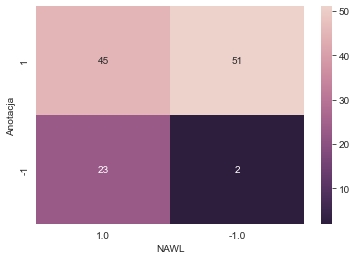

Kappa p1-cat i p1-anot: 0.173


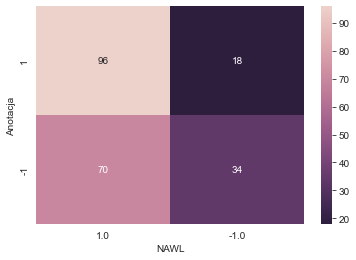

Kappa p2-cat i p2-anot: 0.226


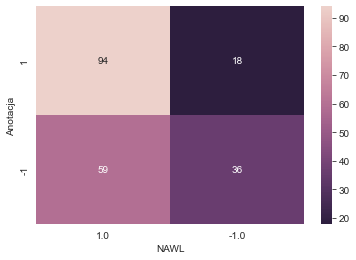

Kappa p3-cat i p3-anot: 0.161


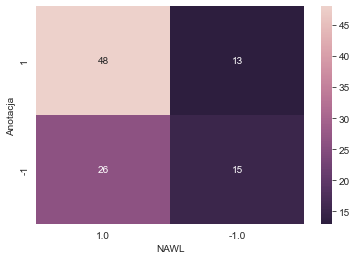

In [116]:
for (pos_column, neg_column) in [('Pos_sentiment_K', 'Neg_sentiment_K'), ('Pos_sentiment_1', 'Neg_sentiment_1'),
                                 ('Pos_sentiment_2', 'Neg_sentiment_2'), ('Pos_sentiment_3', 'Neg_sentiment_3')]:
    if pos_column[-1] == 'K':
        nawl_column = f"k-cat"
        anot_column = f"k-anot"
    else:
        nawl_column = f"p{pos_column[-1]}-cat"
        anot_column = f"p{pos_column[-1]}-anot"


    # liczenie wystąpień -1/0/1 oraz konwersja do formatu który jest wygodny do robienia wykresu
    #cts (counts) => df liczby wystąpień wartości skategoryzowanych
    cts = nawl_df[nawl_column].value_counts().to_frame().reindex([-1, 1, 0])

    fig.add_trace(
        go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
               textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
               marker_colors=pie_colours
               ),
        row=1, col=1
    )

    # df zawierający wartości skategoryzowane z anotacja df (z dwóch kolumn w jedną)
    anot_df = pd.DataFrame(data={'pos': anotacja_df[pos_column], 'neg': anotacja_df[neg_column]})

    anot_df[anot_column] = anot_df.apply(anotacja, axis=1)
    cts = anot_df[anot_column].value_counts().to_frame().reindex([-1, 1, 0]).drop(0)

    fig.add_trace(
        go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
               textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
               marker_colors=pie_colours
               ),
        row=1, col=2
    )

    #usuwanie 0 (wartości nieokreślonych) z nawl_df
    without_zeros = nawl_df.replace(0, nan)
    cts = without_zeros[nawl_column].value_counts().to_frame().reindex([-1, 1, 0])
    fig.add_trace(
        go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
               textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
               marker_colors=pie_colours
               ),
        row=2, col=1
    )

    #łączenie anot_df i nawl_df w jednego df (merged_df)
    merged_df = pd.concat([anot_df[anot_column], nawl_df[nawl_column].reindex(anot_df.index)], axis=1)
    #usuwanie z merged_df ADU (argumentative discurse unikt) lub całych argumentów które były nieokreślone dla bazy nawl
    merged_wo0 = merged_df.drop(merged_df[merged_df[nawl_column] == 0].index)
    cts = merged_wo0[anot_column].value_counts().to_frame().reindex([-1, 1, 0]).drop(0)
    fig.add_trace(
        go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
               textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
               marker_colors=pie_colours
               ),
        row=2, col=2
    )
    fig.update_layout(title_text=pos_column)
    fig.show()

    #tworzenie wizualizacji confusion matrix (tablicy pomyłek) (dla poszczególnych ADU)
    merged_df = pd.concat([nawl_df, anotacja_df.reindex(nawl_df.index)], axis=1)
    merged_wo0 = merged_df.drop(merged_df[merged_df[nawl_column] == 0].index)

    merged_wo0.rename(columns={pos_column: 'pos', neg_column: 'neg'}, inplace=True)
    merged_wo0[anot_column] = merged_wo0.apply(anotacja, axis=1)
    data = {'nawl': merged_wo0[nawl_column],
            'anotacja': merged_wo0[anot_column]}

    data_df = pd.DataFrame(data, columns=['nawl', 'anotacja'])
    confusion_matrix = pd.crosstab(data_df['anotacja'], data_df['nawl'], rownames=['Anotacja'], colnames=['NAWL'])
    confusion_df = confusion_matrix.unstack().reorder_levels(('Anotacja', 'NAWL'))
    print(f"Kappa {nawl_column} i {anot_column}: {round(kappa(confusion_df), 3)}")
    ax = sns.heatmap(confusion_matrix, annot=True, cmap=hm_palette, fmt='.3g')
    ax.invert_yaxis()
    ax.invert_xaxis()
    plt.show()

In [137]:
# Tworzenie df z połączonej całości argumentów (wszystkie AUN) z bazy (K,1,2,3)
# tworzenie "szablonu" z konkluzji
merged_df = pd.concat([nawl_df, anotacja_df.reindex(nawl_df.index)], axis=1)

merged_df.rename(columns={'Pos_sentiment_K': 'pos', 'Neg_sentiment_K': 'neg'}, inplace=True)
merged_df['k-anot'] = merged_df.apply(anotacja, axis=1)

data = {'nawl': merged_df['k-cat'], 'anotacja': merged_df['k-anot']}
all_comparison_df = pd.DataFrame(data, columns=['nawl', 'anotacja'])
# iterowanie po wszystkich kolumnach z oceną przesłanek i "doklejanie do szablonu"
for (pos_column, neg_column) in [('Pos_sentiment_1', 'Neg_sentiment_1'), ('Pos_sentiment_2', 'Neg_sentiment_2'), ('Pos_sentiment_3', 'Neg_sentiment_3')]:
    nawl_column = f"p{pos_column[-1]}-cat"
    anot_column = f"p{pos_column[-1]}-anot"
    merged_df[anot_column] = merged_df[pos_column] - merged_df[neg_column]

    to_be_added = pd.DataFrame({'nawl':     merged_df[nawl_column],
                                'anotacja': merged_df[anot_column]},
                               columns=['nawl', 'anotacja'])
    all_comparison_df = pd.concat([all_comparison_df, to_be_added], ignore_index=True)

In [138]:
all_comparison_df

,nawl,anotacja
0,-1.0,1.0
1,-1.0,-1.0
2,1.0,1.0
3,1.0,-1.0
4,0.0,-1.0
...,...,...
999,NaN,0.0
1000,NaN,0.0
1001,NaN,0.0
1002,1.0,1.0


Kappa dla całości: 0.07


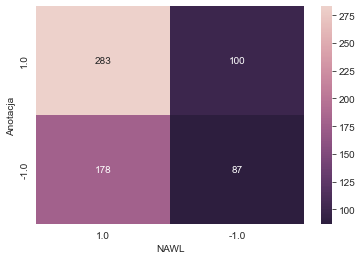

In [139]:
# Confusion matrix dla całości
all_comparison_df_wo0 = all_comparison_df.drop(all_comparison_df[all_comparison_df['nawl'] == 0].index)
confusion_matrix = pd.crosstab(all_comparison_df_wo0['anotacja'], all_comparison_df_wo0['nawl'],
                               rownames=['Anotacja'], colnames=['NAWL'])
confusion_df = confusion_matrix.unstack().reorder_levels(('Anotacja', 'NAWL'))
print(f"Kappa dla całości: {round(kappa(confusion_df), 3)}")
ax = sns.heatmap(confusion_matrix, annot=True, cmap=hm_palette, fmt='.3g')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

In [148]:
cts = all_comparison_df['nawl'].value_counts().to_frame().reindex([-1, 1, 0])
fig.add_trace(
    go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
           textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
           marker_colors=pie_colours
           ),
    row=1, col=1
)
cts = all_comparison_df['anotacja'].value_counts().to_frame().reindex([-1, 1, 0]).drop(0)
fig.add_trace(
    go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
           textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
           marker_colors=pie_colours
           ),
    row=1, col=2
)
cts = all_comparison_df_wo0['nawl'].value_counts().to_frame().reindex([-1, 1, 0])
fig.add_trace(
    go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
           textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
           marker_colors=pie_colours
           ),
    row=2, col=1
)
cts = all_comparison_df_wo0['anotacja'].value_counts().to_frame().reindex([-1, 1, 0]).drop(0)
fig.add_trace(
    go.Pie(labels=[labels_dict[i] for i in cts.index.tolist()], values=[value[0] for value in cts.values.tolist()],
           textposition='inside', textinfo='label+percent+value', insidetextorientation='horizontal',
           marker_colors=pie_colours
           ),
    row=2, col=2
)
fig.update_layout(title_text='Pie chart dla wszystkich AUN')
fig.show()